# Serve Model

## Story
* We have a fully trained TensorFlow model
* TensorFlow models are ideal to bring them into production
* The model is stored as a computational graph and can be executed pretty much anywhere
  1. We can just load the saved model and exeute it from Python or
  1. There is a specific CC built server that can just serve it
  1. It will run in the Cloud as is
  1. Can be integrated into Java
* Even Docker can be made to have access to GPU

In [1]:
!ls -l classifier

total 284
drwxr-xr-x 1 olive 197609      0 Apr 18 11:29 assets
-rw-r--r-- 1 olive 197609  19134 Apr 18 12:54 keras_metadata.pb
-rw-r--r-- 1 olive 197609 264369 Apr 18 12:54 saved_model.pb
drwxr-xr-x 1 olive 197609      0 Apr 18 12:54 variables


## Load and use model from Python

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
# https://www.tensorflow.org/guide/keras/save_and_serialize

reconstructed_model = tf.keras.models.load_model("classifier")
reconstructed_model

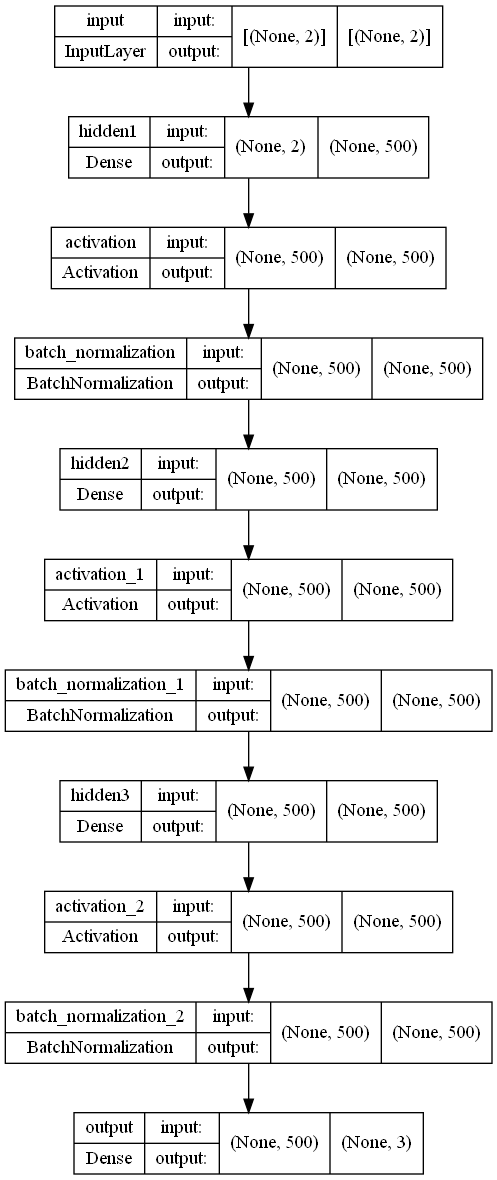

In [4]:
tf.keras.utils.plot_model(reconstructed_model, show_shapes=True)

In [5]:
%%time

reconstructed_model.predict([[48, 100]])

CPU times: total: 234 ms
Wall time: 268 ms


array([[0.03963143, 0.29583058, 0.664538  ]], dtype=float32)

In [6]:
reconstructed_model.signatures

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input) at 0x23EC6319B20>})

In [7]:
inference_fn = reconstructed_model.signatures['serving_default']
inference_fn

<ConcreteFunction signature_wrapper(*, input) at 0x23EC6319B20>

In [8]:
t = tf.convert_to_tensor([[48, 100]], dtype=tf.float32)
t

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 48., 100.]], dtype=float32)>

In [9]:
%%time

reconstructed_model.predict(t)

CPU times: total: 188 ms
Wall time: 197 ms


array([[0.03963143, 0.29583058, 0.664538  ]], dtype=float32)

In [10]:
%%time

inference_fn(input=t)

CPU times: total: 62.5 ms
Wall time: 48.9 ms


{'output': <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.03963143, 0.29583058, 0.664538  ]], dtype=float32)>}

In [11]:
# * https://www.tensorflow.org/guide/intro_to_graphs
# * https://www.tensorflow.org/api_docs/python/tf/Graph#as_graph_def 

# The serialized GraphDef can be imported into another Graph (using tf.import_graph_def) or used with the C++ Session API.

graph = inference_fn.graph.as_graph_def()
type(graph)

tensorflow.core.framework.graph_pb2.GraphDef

In [12]:
graph

node {
  name: "input"
  op: "Placeholder"
  attr {
    key: "_user_specified_name"
    value {
      s: "input"
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 2
        }
      }
    }
  }
}
node {
  name: "unknown"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_0"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_1"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_RESOURCE
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
node {
  name: "unknown_2"
  op: "Placeholder"
  attr {
    key: "dtype"
    val

## Start using Docker

- TensorFlow with Docker: https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/docker.md
- TFX Serving: https://www.tensorflow.org/tfx/serving/docker
- Complete example: https://github.com/embarced/notebooks/tree/master/tfx
- GPU support: 
  - https://www.tensorflow.org/tfx/serving/docker#serving_with_docker_using_your_gpu
  - https://github.com/NVIDIA/nvidia-docker
    - https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html#docker
  - https://docs.docker.com/compose/gpu-support/

In [8]:
!curl -d '{"instances": [[50.0, 122.0], [48, 100], [30, 150]]}' -X POST http://localhost:8501/v1/models/insurance:predict

{
    "predictions": [[0.184337184, 0.28695032, 0.528712511], [0.0255763717, 0.198027506, 0.776396155], [0.947066486, 0.041994229, 0.0109393876]
    ]
}

## Load and use model from C++ server

* https://github.com/tensorflow/serving
* will run on Linux only

In [13]:
!saved_model_cli show --dir classifier --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: serving_default_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 3)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          input: TensorSpec(shape=(None, 

2022-04-18 13:29:12.737578: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-18 13:29:12.737619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
!pwd

/c/Users/olive/Development/insurance-ml/notebooks


In [15]:
!mkdir insurance

A subdirectory or file insurance already exists.


In [17]:
!cp -R classifier insurance/1

In [6]:
%%bash --bg 

# to get at least basic logging of requests
export TF_CPP_VMODULE=http_server=1

nohup tensorflow_model_server --port=8500 --rest_api_port=8501 \
  --model_name=insurance --model_base_path=/home/olli/notebooks/mlops/insurance  >server.log 2>&1

In [10]:
!tail server.log

2021-11-07 10:17:41.043760: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:194] Running initialization op on SavedModel bundle at path: /home/olli/notebooks/mlops/insurance/1
2021-11-07 10:17:41.056323: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:283] SavedModel load for tags { serve }; Status: success: OK. Took 78546 microseconds.
2021-11-07 10:17:41.057142: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /home/olli/notebooks/mlops/insurance/1/assets.extra/tf_serving_warmup_requests
2021-11-07 10:17:41.057625: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: insurance version: 1}
2021-11-07 10:17:41.059234: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-11-07 10:17:41.059269: I tensorflow_serving/model_servers/server.cc:133] Using InsecureServerCredentials
2021-11-07 10:17:41.059276: I tensorflow_serving/model_se